# JSON Schema Bench — Failure Analysis

Loads all provider results for a given run, filters failures, and graphs failure types per task per provider.

In [73]:
import sys
from pathlib import Path

# Make sure the bench modules are importable
BENCH_ROOT = Path(".").resolve()
if str(BENCH_ROOT) not in sys.path:
    sys.path.insert(0, str(BENCH_ROOT))

import json
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np


## Configuration

Set  to the folder name under  that you want to analyse.

In [75]:
RUN_ID      = "2026-02-17-10-35-16"
MODEL_FILTER = "MiniMaxAI_MiniMax-M2.5"   # e.g. "MiniMaxAI_MiniMax-M2.5"  — set to None to load all models

OUTPUTS_ROOT = BENCH_ROOT / "outputs" / RUN_ID / "openai_compatible"
print(f"Loading results from: {OUTPUTS_ROOT}")

providers = [p.name for p in OUTPUTS_ROOT.iterdir() if p.is_dir()]
print(f"Providers found: {providers}")

# Show every model present so the user can pick one for MODEL_FILTER
available_models = sorted({
    jl.stem
    for p in providers
    for jl in (OUTPUTS_ROOT / p).glob("*.jsonl")
})
print(f"Models available in this run: {available_models}")
if MODEL_FILTER:
    print(f"  → Filtering to model: {MODEL_FILTER!r}")


Loading results from: /Users/jorgep/Documents/FC_QA/fc-so-testing-suite/tests/jsonschemabench_snova/outputs/2026-02-17-10-35-16/openai_compatible
Providers found: ['sambanova', 'together', 'fireworks', 'novita']
Models available in this run: ['MiniMaxAI_MiniMax-M2.5']
  → Filtering to model: 'MiniMaxAI_MiniMax-M2.5'


## Load Results

In [76]:
engine_configs = {}   # (provider, model_stem) -> engine_config dict

def load_provider_results(provider_dir: Path) -> list:
    """Load all JSONL files under a provider directory.

    Returns a flat list of record dicts, each augmented with
    provider and model keys.
    Also populates the module-level engine_configs dict.
    """
    records = []
    for jsonl_path in sorted(provider_dir.glob("*.jsonl")):
        model_name = jsonl_path.stem
        provider_name = provider_dir.name
        # Skip files that don't match the requested model
        if MODEL_FILTER and model_name != MODEL_FILTER:
            continue
        with open(jsonl_path) as f:
            lines = f.readlines()
        if not lines:
            continue
        # Line 0 is the engine config -- parse and store it
        try:
            cfg = json.loads(lines[0])
            engine_configs[(provider_name, model_name)] = cfg
        except json.JSONDecodeError:
            pass
        for line in lines[1:]:
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
            except json.JSONDecodeError:
                continue
            rec["provider"] = provider_name
            rec["model"] = model_name
            records.append(rec)
    return records


all_records = []
for provider in providers:
    provider_dir = OUTPUTS_ROOT / provider
    recs = load_provider_results(provider_dir)
    all_records.extend(recs)
    print(f"  {provider}: {len(recs)} records")

print(f"\nTotal records: {len(all_records)}")
print(f"Engine configs loaded: {list(engine_configs.keys())}")
models_loaded = sorted({r["model"] for r in all_records})
print(f"Models in analysis: {models_loaded}")


  sambanova: 938 records
  together: 600 records
  fireworks: 938 records
  novita: 938 records

Total records: 3414
Engine configs loaded: [('sambanova', 'MiniMaxAI_MiniMax-M2.5'), ('together', 'MiniMaxAI_MiniMax-M2.5'), ('fireworks', 'MiniMaxAI_MiniMax-M2.5'), ('novita', 'MiniMaxAI_MiniMax-M2.5')]
Models in analysis: ['MiniMaxAI_MiniMax-M2.5']


## Build DataFrame

In [77]:
rows = []
for rec in all_records:
    metadata = rec.get("metadata", {})
    rows.append({
        "id":           rec.get("id"),
        "provider":     rec.get("provider"),
        "model":        rec.get("model"),
        "task":         rec.get("task"),
        "failure":      bool(metadata.get("failure", False)),
        "failure_type": metadata.get("failure_type") or "none",
    })

df = pd.DataFrame(rows)

print(df.groupby(["provider", "failure"]).size().unstack(fill_value=0))
df.head()


failure    False  True 
provider               
fireworks    588    350
novita         0    938
sambanova    491    447
together     352    248


,id,provider,model,task,failure,failure_type
0,bb86939e-3011-41e8-bd2f-a76d2e3eb5b1,sambanova,MiniMaxAI_MiniMax-M2.5,Github_easy,False,none
1,0c4f3117-3fd2-4e10-8d5d-764823b91546,sambanova,MiniMaxAI_MiniMax-M2.5,Github_easy,False,none
2,a79aafc3-b150-4514-97ee-26b6a3e36c2c,sambanova,MiniMaxAI_MiniMax-M2.5,Github_easy,True,Generation is not json parsable
3,dbe9b80e-1a68-4eaa-8811-d922979903d8,sambanova,MiniMaxAI_MiniMax-M2.5,Github_easy,False,none
4,57df5bce-6d39-415d-82b1-6128a791906e,sambanova,MiniMaxAI_MiniMax-M2.5,Github_easy,False,none


## Failure Summary

In [78]:
failures = df[df["failure"] == True].copy()

print(f"Total failures: {len(failures)} / {len(df)} ({100*len(failures)/len(df):.1f}%)")
print()
print("Failure type distribution:")
print(failures["failure_type"].value_counts().to_string())


Total failures: 1983 / 3414 (58.1%)

Failure type distribution:
failure_type
Generation is not json parsable                          1821
Generated json is not instance of the provided schema     162


## Failure Types per Task per Provider

One subplot per task. Each subplot shows, for every provider, a stacked bar of failure counts broken down by failure type.

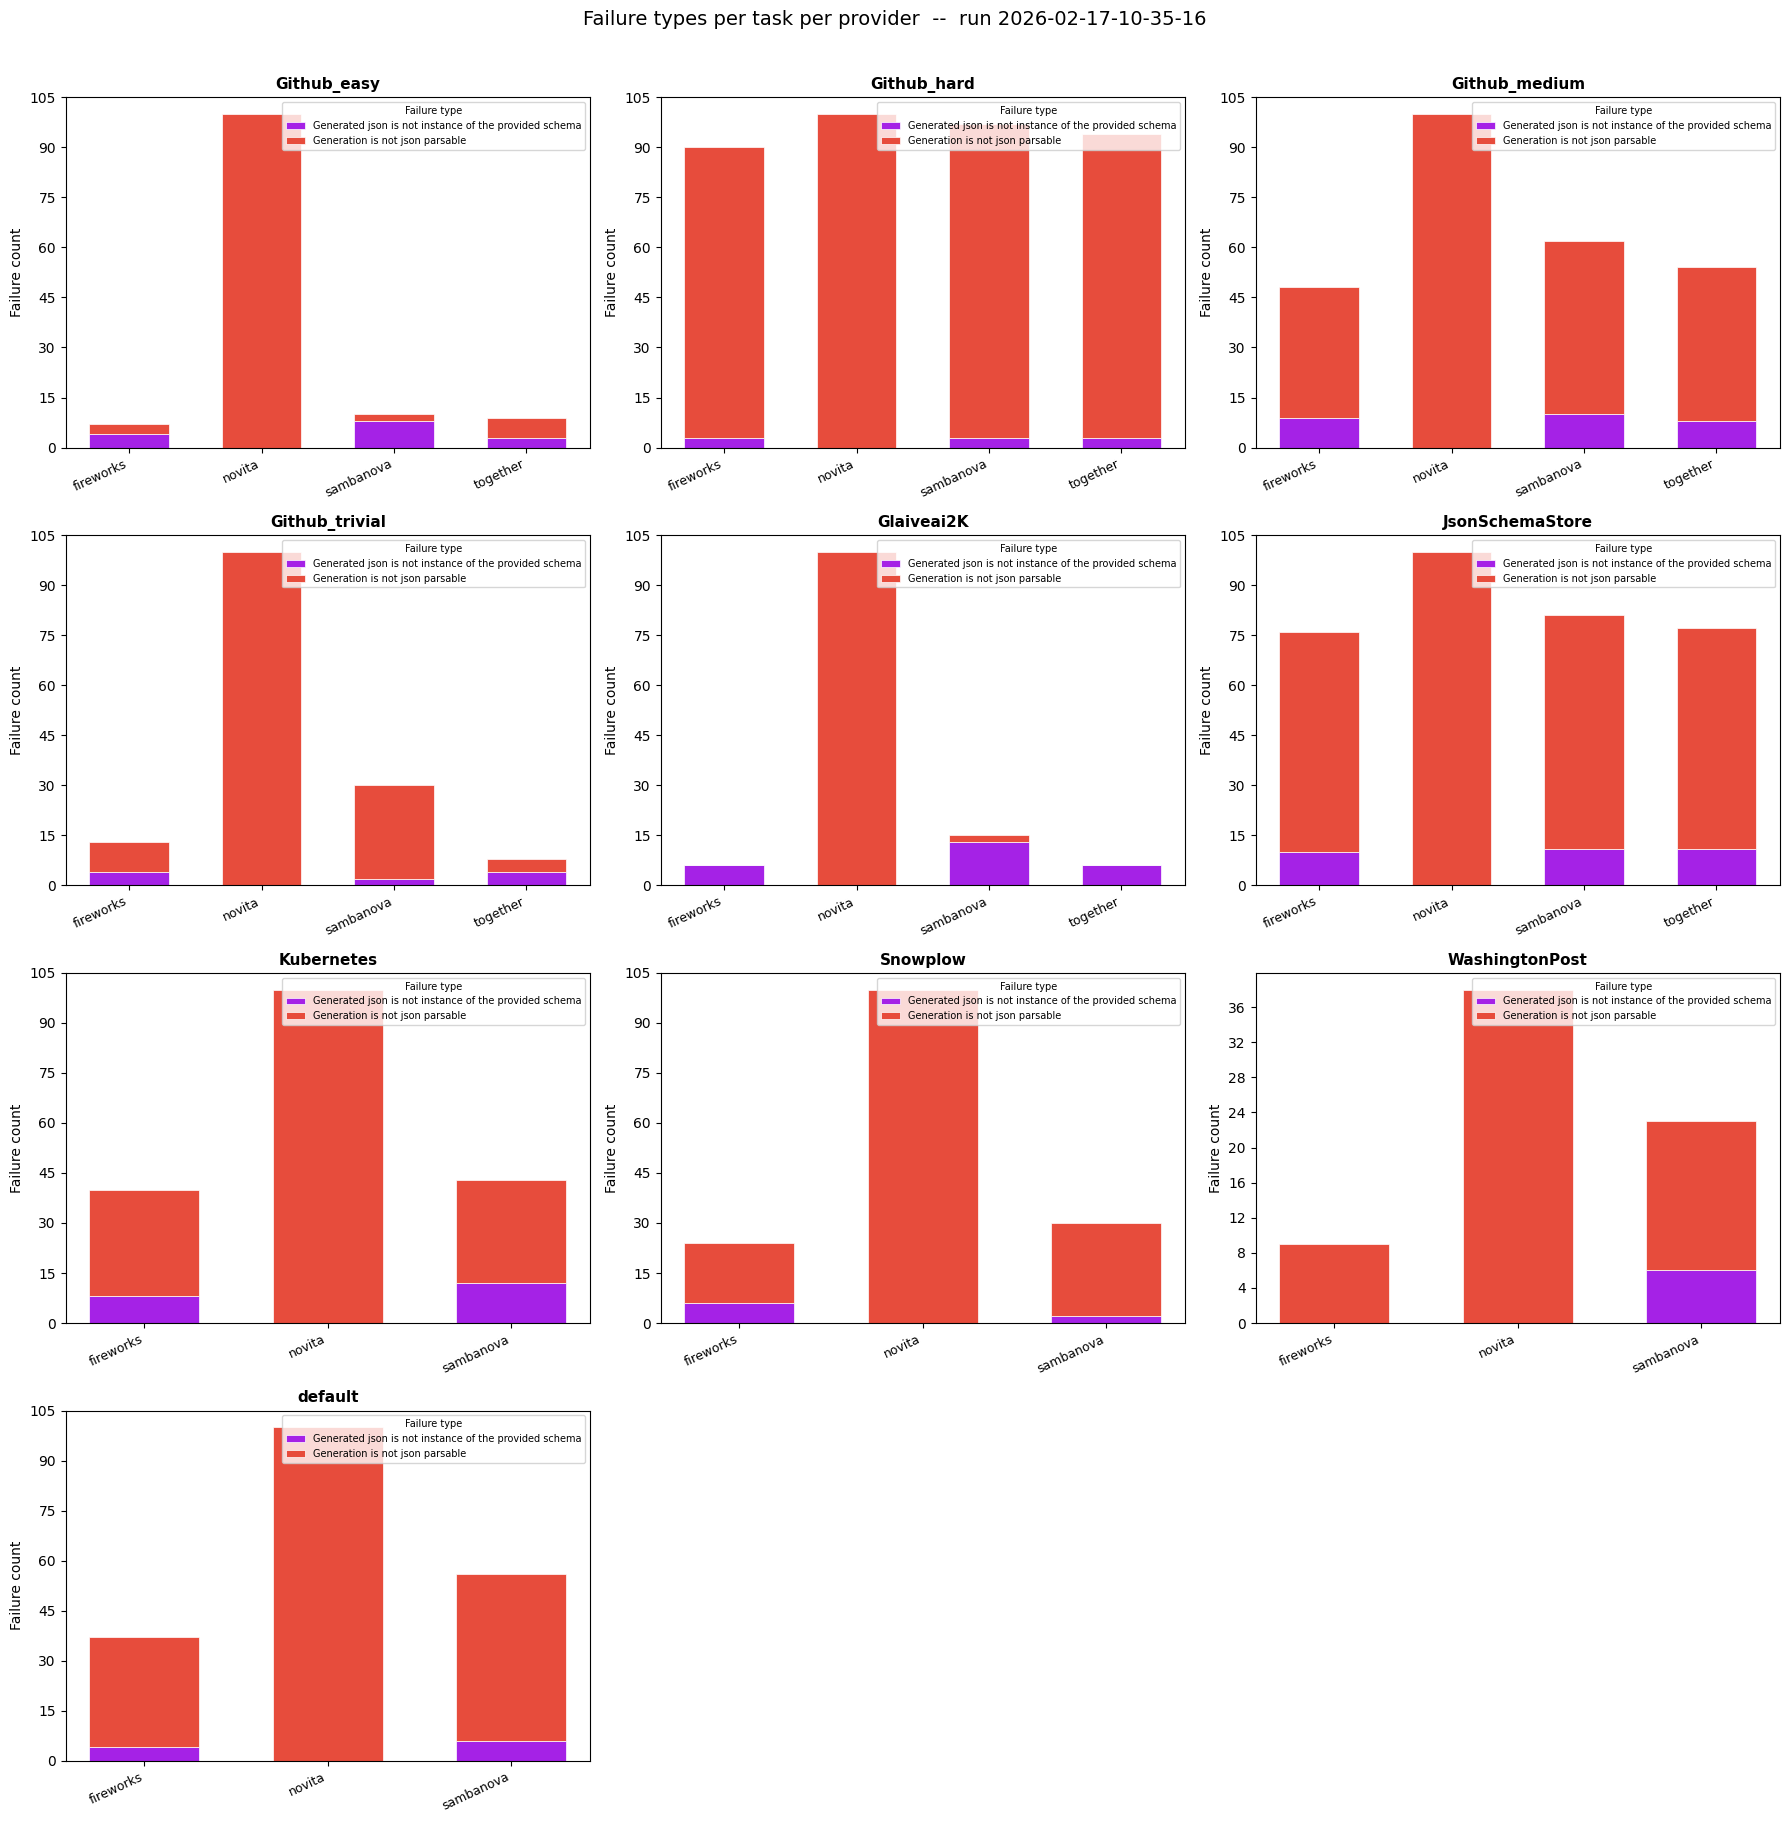

In [79]:
FAILURE_COLORS = {
    "Empty generation or schema":                               "#9fb659",
    "Generated json is not instance of the provided schema":    "#a522e6",
    "Generation is not json parsable":                          "#e74c3c",
}
DEFAULT_COLOR = "#95a5a6"

tasks = sorted(failures["task"].unique())
failure_types = sorted(failures["failure_type"].unique())

n_tasks = len(tasks)
if n_tasks == 0:
    print("No failures found -- nothing to plot.")
else:
    ncols = min(3, n_tasks)
    nrows = (n_tasks + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(6 * ncols, 4.5 * nrows),
        squeeze=False,
    )

    for idx, task in enumerate(tasks):
        ax = axes[idx // ncols][idx % ncols]
        task_df = failures[failures["task"] == task]

        # pivot: rows = provider, cols = failure_type, values = count
        pivot = (
            task_df.groupby(["provider", "failure_type"])
            .size()
            .unstack(fill_value=0)
            .reindex(columns=failure_types, fill_value=0)
        )

        x = np.arange(len(pivot))
        bar_width = 0.6
        bottom = np.zeros(len(pivot))

        for ft in failure_types:
            counts = pivot[ft].values
            color = FAILURE_COLORS.get(ft, DEFAULT_COLOR)
            ax.bar(
                x, counts, bar_width,
                bottom=bottom,
                label=ft,
                color=color,
                edgecolor="white",
                linewidth=0.5,
            )
            bottom += counts

        ax.set_title(task, fontsize=11, fontweight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(pivot.index, rotation=25, ha="right", fontsize=9)
        ax.set_ylabel("Failure count")
        ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        ax.legend(
            fontsize=7, loc="upper right", framealpha=0.8,
            title="Failure type", title_fontsize=7,
        )

    # hide unused subplots
    for idx in range(n_tasks, nrows * ncols):
        axes[idx // ncols][idx % ncols].set_visible(False)

    fig.suptitle(
        f"Failure types per task per provider  --  run {RUN_ID}",
        fontsize=14, y=1.01,
    )
    plt.tight_layout()
    plt.show()


## Overall Failure Rate per Provider

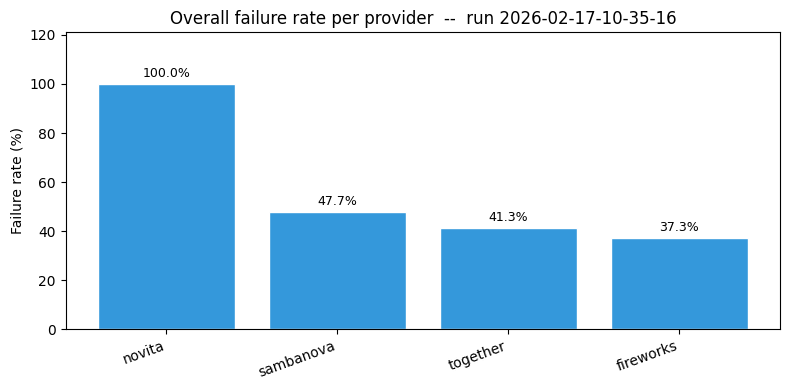

           total  failed  failure_rate
provider                              
novita       938     938    100.000000
sambanova    938     447     47.654584
together     600     248     41.333333
fireworks    938     350     37.313433


In [80]:
provider_stats = (
    df.groupby("provider")["failure"]
    .agg(total="count", failed="sum")
    .assign(failure_rate=lambda d: 100 * d["failed"] / d["total"])
    .sort_values("failure_rate", ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    provider_stats.index,
    provider_stats["failure_rate"],
    color="#3498db",
    edgecolor="white",
)
ax.bar_label(bars, fmt="%.1f%%", padding=3, fontsize=9)
ax.set_ylabel("Failure rate (%)")
ax.set_title(f"Overall failure rate per provider  --  run {RUN_ID}")
ax.set_ylim(0, max(provider_stats["failure_rate"]) * 1.2 + 1)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

print(provider_stats.to_string())


## Cross-Provider Comparison

Finds test cases that failed for one provider but passed for others.

Each test case is identified by a stable hash of its schema content (`schema_key`),
so the same schema run across different providers can be correlated.


In [81]:
import hashlib

# Build id -> raw record lookup (used for schema access and debug)
records_by_id = {r["id"]: r for r in all_records if r.get("id")}

def _schema_key(rec: dict) -> str:
    """Stable 12-char hex hash of the schema content."""
    schema = rec.get("schema") or {}
    return hashlib.md5(json.dumps(schema, sort_keys=True).encode()).hexdigest()[:12]

schema_key_map = {rid: _schema_key(rec) for rid, rec in records_by_id.items()}
df["schema_key"] = df["id"].map(schema_key_map)
print("schema_key column added.")
df[["id", "schema_key", "task", "provider", "failure", "failure_type"]].head()


schema_key column added.


,id,schema_key,task,provider,failure,failure_type
0,bb86939e-3011-41e8-bd2f-a76d2e3eb5b1,3d5cb47c7c2f,Github_easy,sambanova,False,none
1,0c4f3117-3fd2-4e10-8d5d-764823b91546,8793e8b68139,Github_easy,sambanova,False,none
2,a79aafc3-b150-4514-97ee-26b6a3e36c2c,9eea0f245b5f,Github_easy,sambanova,True,Generation is not json parsable
3,dbe9b80e-1a68-4eaa-8811-d922979903d8,e31fcc75532c,Github_easy,sambanova,False,none
4,57df5bce-6d39-415d-82b1-6128a791906e,63a73b515e15,Github_easy,sambanova,False,none


In [82]:
# ── configure ──────────────────────────────────────────────────────────────────
FOCUS_PROVIDER  = "sambanova"   # provider whose unique failures you want
COMPARE_AGAINST = ["fireworks", "together"]        # None = all other providers; or e.g. ["fireworks"]
# ───────────────────────────────────────────────────────────────────────────────

other_providers = [p for p in providers if p != FOCUS_PROVIDER]
if COMPARE_AGAINST:
    other_providers = [p for p in COMPARE_AGAINST if p != FOCUS_PROVIDER]

# Pivot: (task, schema_key) x provider -> failure bool
pivot = (
    df.groupby(["task", "schema_key", "provider"])["failure"]
    .first()
    .unstack()
)

# Keep only rows where both the focus provider and all comparison providers have data
required_cols = [FOCUS_PROVIDER] + other_providers
pivot = pivot.dropna(subset=required_cols)

failed_in_focus  = pivot[FOCUS_PROVIDER] == True
passed_in_others = pivot[other_providers].eq(False).all(axis=1)

exclusive_idx = pivot[failed_in_focus & passed_in_others].reset_index()[["task", "schema_key"]]
print(f"Cases failed in '{FOCUS_PROVIDER}' but passed in all of {other_providers}: {len(exclusive_idx)}")

# Join back the failure details for the focus provider
focus_details = (
    df[(df["provider"] == FOCUS_PROVIDER)]
    [["id", "task", "schema_key", "failure_type"]]
)
exclusive = exclusive_idx.merge(focus_details, on=["task", "schema_key"], how="left")

print()
print(exclusive.groupby(["task", "failure_type"]).size().rename("count").reset_index().to_string(index=False))
exclusive.head(20)


Cases failed in 'sambanova' but passed in all of ['fireworks', 'together']: 60

           task                                          failure_type  count
    Github_easy Generated json is not instance of the provided schema      4
    Github_easy                       Generation is not json parsable      1
    Github_hard                       Generation is not json parsable      3
  Github_medium Generated json is not instance of the provided schema      2
  Github_medium                       Generation is not json parsable     14
 Github_trivial Generated json is not instance of the provided schema      1
 Github_trivial                       Generation is not json parsable     21
     Glaiveai2K Generated json is not instance of the provided schema      8
     Glaiveai2K                       Generation is not json parsable      2
     Glaiveai2K                                                  none      1
JsonSchemaStore Generated json is not instance of the provided schema    

,task,schema_key,id,failure_type
0,Github_easy,2239bd1a6e5c,c194cef9-8244-4884-8452-678dec6e0074,Generated json is not instance of the provided...
1,Github_easy,312a52b43870,79917db8-cede-4078-a939-dcbbb458e8c8,Generated json is not instance of the provided...
2,Github_easy,3653805fd30c,d3096fc1-2e20-4086-9a85-839d33558ca7,Generated json is not instance of the provided...
3,Github_easy,9eea0f245b5f,a79aafc3-b150-4514-97ee-26b6a3e36c2c,Generation is not json parsable
4,Github_easy,a01d06bef6f1,f3a8b645-0bf7-46a1-b284-56417a55448b,Generated json is not instance of the provided...
5,Github_hard,68ec9050e0f7,3aed363a-e681-4935-b3dd-50148bef78b4,Generation is not json parsable
6,Github_hard,acdf31a557b7,0c906765-ec87-496c-91dd-13e6a1b06598,Generation is not json parsable
7,Github_hard,bc9057e211d9,b41fb8d2-25af-49d1-926e-4d9a20b35d16,Generation is not json parsable
8,Github_medium,1c63fd526704,83f61ebe-652e-44c2-aa59-0c5975371b8a,Generated json is not instance of the provided...
9,Github_medium,20aa80812615,fc441c28-93a2-4ccc-b545-599a7ce7403b,Generation is not json parsable


## Debug: Inspect a Specific Failing Case

Pick any `id` from the `exclusive` table above (or from `failures`) and paste it into `INSPECT_ID`.
The cell will print the full schema, the model's generation, the error, and how every other provider handled the exact same schema.


In [83]:
# ── configure ──────────────────────────────────────────────────────────────────
INSPECT_ID = exclusive["id"].iloc[0]   # replace with any id from the table above
# ───────────────────────────────────────────────────────────────────────────────

rec = records_by_id[INSPECT_ID]
md  = rec.get("metadata", {})

sep = lambda title: print(f"\n{'─'*60}\n  {title}\n{'─'*60}")

sep("CASE INFO")
print(f"  id:           {rec['id']}")
print(f"  task:         {rec['task']}")
print(f"  provider:     {rec['provider']}  /  {rec['model']}")
print(f"  failure:      {md.get('failure')}")
print(f"  failure_type: {md.get('failure_type')}")

sep("SCHEMA")
print(json.dumps(rec.get("schema", {}), indent=2))

compile_msg = (md.get("compile_status") or {}).get("message")
if compile_msg:
    sep("COMPILE / API ERROR")
    print(compile_msg)

decoding_msg = (md.get("decoding_status") or {}).get("message")
if decoding_msg:
    sep("DECODING ERROR")
    print(decoding_msg)

# ── generations across all providers for this schema ──────────────────────────
sk = schema_key_map.get(INSPECT_ID)
same_cases = [
    r for r in all_records
    if r.get("task") == rec["task"] and schema_key_map.get(r.get("id")) == sk
]

sep("GENERATIONS ACROSS ALL PROVIDERS")
for r in same_cases:
    r_md   = r.get("metadata", {})
    status = "✗ FAIL" if r_md.get("failure") else "✓ PASS"
    ft     = f"  ← {r_md['failure_type']}" if r_md.get("failure_type") else ""
    marker = "► " if r["provider"] == rec["provider"] else "  "
    print(f"\n{marker}[{status}]  {r['provider']}  /  {r['model']}{ft}")
    print(repr(r.get("generation")) or "(empty)")

# ── curl reconstruction ────────────────────────────────────────────────────────
sep("CURL TO REPLICATE")

cfg         = engine_configs.get((rec["provider"], rec["model"]), {})
ec          = cfg.get("engine_config", {})
base_url    = ec.get("base_url", "https://<base_url>").rstrip("/")
model_name  = ec.get("model", rec["model"])
max_tokens  = ec.get("max_tokens", 512)
api_key_var = ec.get("api_key_variable_name", "API_KEY")

messages = rec.get("messages", [])
schema   = rec.get("schema", {})
schema_name = schema.get("title") or rec.get("task") or "schema"

payload = {
    "model": model_name,
    "max_tokens": max_tokens,
    "messages": messages,
    "response_format": {
        "type": "json_schema",
        "json_schema": {
            "name": schema_name,
            "strict": False,
            "schema": schema,
        },
    },
}

curl = (
    f"curl --location '{base_url}/chat/completions' \\\n"
    f"--header 'Content-Type: application/json' \\\n"
    f"--header 'Authorization: Bearer ${{{api_key_var}}}' \\\n"
    f"--data '{json.dumps(payload, indent=4)}'"
)

print(curl)



────────────────────────────────────────────────────────────
  CASE INFO
────────────────────────────────────────────────────────────
  id:           c194cef9-8244-4884-8452-678dec6e0074
  task:         Github_easy
  provider:     sambanova  /  MiniMaxAI_MiniMax-M2.5
  failure:      True
  failure_type: Generated json is not instance of the provided schema

────────────────────────────────────────────────────────────
  SCHEMA
────────────────────────────────────────────────────────────
{
  "$schema": "http://json-schema.org/draft-04/schema#",
  "type": "array",
  "items": {
    "type": "object",
    "properties": {
      "id": {
        "type": "string"
      },
      "title": {
        "type": "string"
      },
      "description": {
        "type": "string"
      },
      "journal": {
        "type": "string"
      },
      "question": {
        "type": "number"
      },
      "races": {
        "type": "array",
        "items": {
          "type": "string"
        }
      },
      